# Part 2: Better regression model

## Importing libraries

In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Extracting data

In [2]:

#----------------------Function to extract the data from the file--------------
def extract_info(hashtag):
    hashtag_dictionary = {'#GoHawks' : ['tweets_#gohawks.txt', 188136],
                          '#GoPatriots' : ['tweets_#gopatriots.txt', 26232],
                          '#NFL' : ['tweets_#nfl.txt', 259024],
                          '#Patriots' : ['tweets_#patriots.txt', 489713],
                          '#SB49' : ['tweets_#sb49.txt', 826951],
                          '#SuperBowl' : ['tweets_#superbowl.txt', 1348767]}             

    #-----------------------To extract the data from the file------------------                
    time_stamps = [0]*hashtag_dictionary[hashtag][1]
    is_retweet = [False]*hashtag_dictionary[hashtag][1]
    followers_of_users = [0]*hashtag_dictionary[hashtag][1]
    
    no_of_url_citations = [0]*hashtag_dictionary[hashtag][1]
    usernames = ['']*hashtag_dictionary[hashtag][1]
    no_of_mentions = [0]*hashtag_dictionary[hashtag][1]
    ranking_scores = [0.0]*hashtag_dictionary[hashtag][1]
    no_of_hashtags = [0]*hashtag_dictionary[hashtag][1]
    
    file_in = open('./Training_data/'+hashtag_dictionary[hashtag][0], encoding="utf8")
    for (line, index) in zip(file_in, range(0, hashtag_dictionary[hashtag][1])):
        tr_data = json.loads(line)
        time_stamps[index] = tr_data['citation_date']
        followers_of_users[index] = tr_data['author']['followers']

        username = tr_data['author']['nick']
        original_username = tr_data['original_author']['nick']
        if username != original_username:
            is_retweet[index] = True

        no_of_url_citations[index] = len(tr_data['tweet']['entities']['urls'])
        usernames[index] = username
        no_of_mentions[index] = len(tr_data['tweet']['entities']['user_mentions'])
        ranking_scores[index] = tr_data['metrics']['ranking_score']
        no_of_hashtags[index] = tr_data['title'].count('#')
        
    file_in.close()
    
    #--------------------To calculate the related parameters-------------------
    hrs_passed = int((max(time_stamps)-min(time_stamps))/3600)+1
    hr_no_of_tweets = [0] * hrs_passed
    hr_no_of_retweets = [0] * hrs_passed
    hr_sum_of_followers = [0] * hrs_passed
    hr_max_no_of_followers = [0] * hrs_passed
    hr_time_of_the_day = [0] * hrs_passed
    hr_no_of_url_citations = [0] * hrs_passed
    hr_no_of_users = [0] * hrs_passed
    hr_user_set = [0] * hrs_passed
    hr_no_of_mentions = [0] * hrs_passed
    hr_total_ranking_scores = [0.0] * hrs_passed
    hr_no_of_hashtags = [0] * hrs_passed
    for i in range(0, hrs_passed):
        hr_user_set[i] = set([])
    
    start_time = min(time_stamps)
    for i in range(0, hashtag_dictionary[hashtag][1]):
        current_hr = int((time_stamps[i]-start_time)/3600)
        
        hr_no_of_tweets[current_hr] += 1
        
        if is_retweet[i]:
            hr_no_of_retweets[current_hr] += 1
    
        if followers_of_users[i] > hr_max_no_of_followers[current_hr]:
            hr_max_no_of_followers[current_hr] = followers_of_users[i]

        hr_sum_of_followers[current_hr] += followers_of_users[i]
        hr_no_of_url_citations[current_hr] += no_of_url_citations[i]
        hr_user_set[current_hr].add(usernames[i])
        hr_no_of_mentions[current_hr] += no_of_mentions[i]
        hr_total_ranking_scores[current_hr] += ranking_scores[i]
        hr_no_of_hashtags[current_hr] += no_of_hashtags[i]

    for i in range(0, len(hr_user_set)):
        hr_no_of_users[i] = len(hr_user_set[i])
    
    for i in range(0, len(hr_time_of_the_day)):
        hr_time_of_the_day[i] = i%24

    #------------------To build the DataFrame and save it to file--------------
    target = hr_no_of_tweets[1:]
    target.append(0)
    
    data = np.array([hr_no_of_tweets,
                     hr_no_of_retweets,
                     hr_sum_of_followers,
                     hr_max_no_of_followers,
                     hr_time_of_the_day,
                     hr_no_of_url_citations,
                     hr_no_of_users,
                     hr_no_of_mentions,
                     hr_total_ranking_scores,
                     hr_no_of_hashtags,
                     target])
    data = np.transpose(data)
    
    data_frame = DataFrame(data)
    data_frame.columns = ['no_of_tweets', 
                          'no_of_retweets', 
                          'sum_of_followers',
                          'max_no_of_followers',
                          'time_of_day',
                          'no_of_URLs',
                          'no_of_users',
                          'no_of_mentions',
                          'ranking_score',
                          'no_of_hashtags',
                          'target']
    
    if os.path.isdir('./Extracted_data'):
        pass
    else:
        os.mkdir('./Extracted_data')
    
    data_frame.to_csv('./Extracted_data/data2_'+hashtag+'.csv', index = False)   
#------------------------------------------------------------------------------      


## Linear regression function

In [3]:

#-------------------Function to perform Linear Regression----------------------
def linear_regression(hashtag):
    training_data = pd.read_csv('./Extracted_data/data2_'+hashtag+'.csv')
    
    #----------------------------One-hot Encoding------------------------------
    time_of_day_set = range(0,24)
    for time_of_day in time_of_day_set:
        time_of_day_column_to_add = []
        for time_of_day_item in training_data['time_of_day']:
            if time_of_day_item == time_of_day:
                time_of_day_column_to_add.append(1)
            else:
                time_of_day_column_to_add.append(0)
        training_data.insert(training_data.shape[1]-1,
                             str(time_of_day)+'th_hour',
                             time_of_day_column_to_add)
      
    #---------------------------Linear Regression------------------------------
    training_data.drop('time_of_day', 1, inplace = True)
    target_data = training_data.pop('target')
    
    lin_reg = LinearRegression(fit_intercept = False)
    lin_reg_result = lin_reg.fit(training_data, target_data)
    
    predicted_values = lin_reg_result.predict(training_data)
    
    print('R-squared measure:') 
    print(lin_reg_result.score(training_data, target_data))
    print('RMSE:')
    print(math.sqrt(mean_squared_error(target_data,predicted_values)))
    
    #-----------------------------To perform the t-test------------------------
    model = sm.OLS(target_data, training_data)
    results = model.fit()
    print(results.summary())
    
    #--------------------------To plot the top 3 features----------------------
    plt.clf
    fig, ax = plt.subplots()
    ax.scatter(training_data['no_of_tweets'], predicted_values)
    ax.set_xlabel('Number of Tweets', fontsize = 10)
    ax.set_ylabel('Predicted values', fontsize = 10)
    plt.title('Predicted values vs. Number of Tweets', fontsize = 16)
    plt.show()

    plt.clf
    fig, ax = plt.subplots()
    ax.scatter(training_data['no_of_users'], predicted_values)
    ax.set_xlabel('Number of Users', fontsize = 10)
    ax.set_ylabel('Predicted values', fontsize = 10)
    plt.title('Predicted values vs. Number of Users', fontsize = 16)
    plt.show()
    
    plt.clf
    fig, ax = plt.subplots()
    ax.scatter(training_data['ranking_score'], predicted_values)
    ax.set_xlabel('Ranking Scores', fontsize = 10)
    ax.set_ylabel('Predicted values', fontsize = 10)
    plt.title('Predicted values vs. Ranking Scores', fontsize = 16)
    plt.show()
#------------------------------------------------------------------------------      


In [4]:
def perform_linear_regression(hashtag):
    print('-------------------------------------------------------')
    print('Processing hashtag "' + hashtag + '".\n')
    extract_info(hashtag)
    linear_regression(hashtag)

-------------------------------------------------------
Processing hashtag "#GoHawks".

R-squared measure:
0.7235494966740081
RMSE:
700.1174662302659
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     44.66
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          1.19e-130
Time:                        18:35:43   Log-Likelihood:                -4614.7
No. Observations:                 579   AIC:                             9295.
Df Residuals:                     546   BIC:                             9439.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>

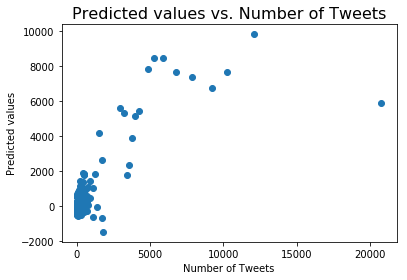

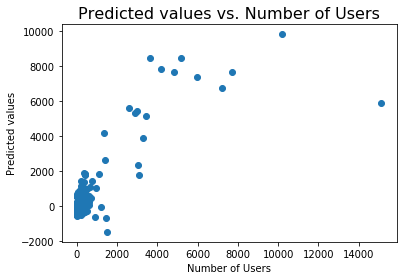

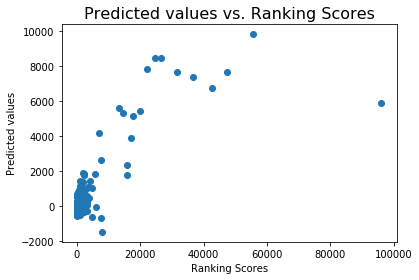

-------------------------------------------------------
Processing hashtag "#GoPatriots".

R-squared measure:
0.8942784488965866
RMSE:
100.15289056780102
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     143.3
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          2.45e-241
Time:                        18:35:47   Log-Likelihood:                -3464.7
No. Observations:                 575   AIC:                             6995.
Df Residuals:                     542   BIC:                             7139.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t    

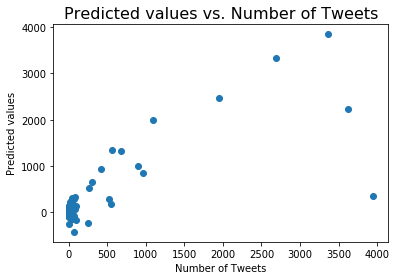

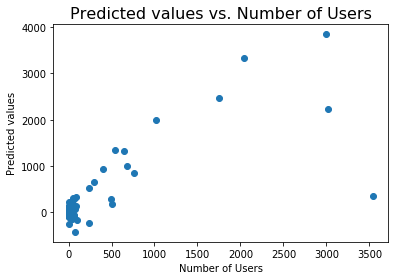

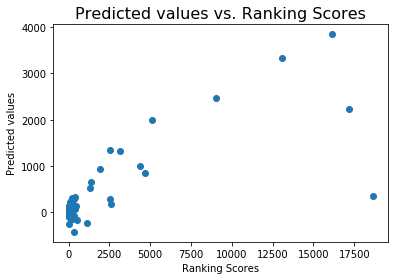

-------------------------------------------------------
Processing hashtag "#NFL".

R-squared measure:
0.764663727036089
RMSE:
426.97393700371094
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     56.25
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          8.37e-152
Time:                        18:37:22   Log-Likelihood:                -4388.2
No. Observations:                 587   AIC:                             8842.
Df Residuals:                     554   BIC:                             8987.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t| 

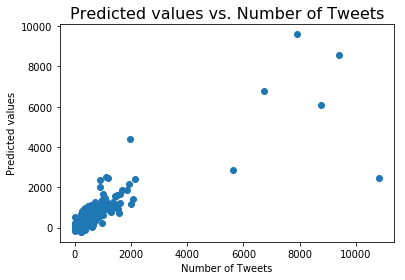

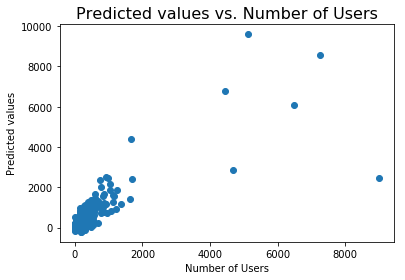

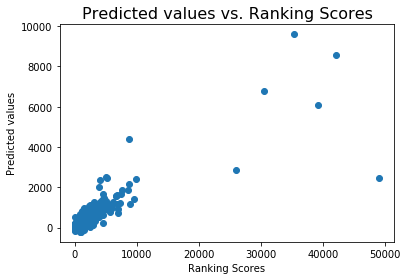

-------------------------------------------------------
Processing hashtag "#Patriots".

R-squared measure:
0.8228697833337947
RMSE:
1840.1375511286992
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     80.43
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          1.65e-185
Time:                        18:39:32   Log-Likelihood:                -5245.7
No. Observations:                 587   AIC:                         1.056e+04
Df Residuals:                     554   BIC:                         1.070e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      

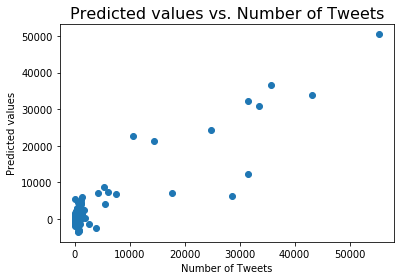

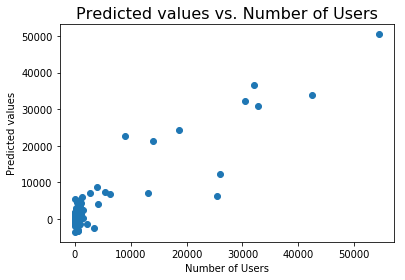

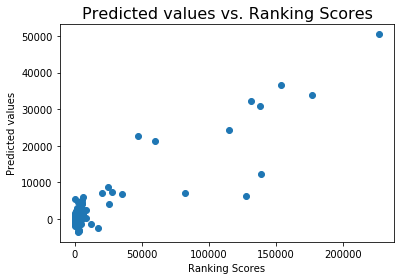

-------------------------------------------------------
Processing hashtag "#SB49".

R-squared measure:
0.9018514036578683
RMSE:
3143.1473539568938
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     157.9
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          5.72e-254
Time:                        18:43:09   Log-Likelihood:                -5522.1
No. Observations:                 583   AIC:                         1.111e+04
Df Residuals:                     550   BIC:                         1.125e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t

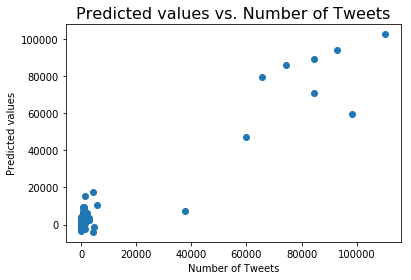

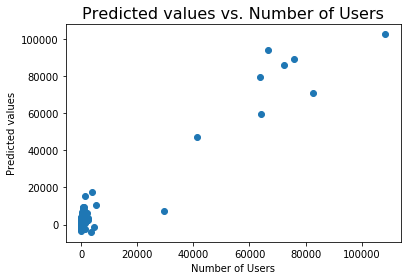

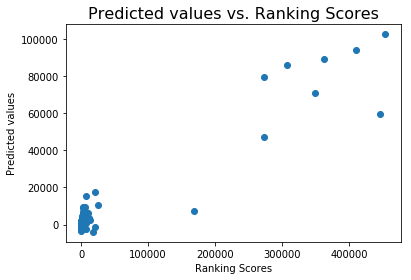

-------------------------------------------------------
Processing hashtag "#SuperBowl".

R-squared measure:
0.9430858517592228
RMSE:
4260.876213460498
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     286.4
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          1.36e-320
Time:                        18:48:22   Log-Likelihood:                -5728.8
No. Observations:                 586   AIC:                         1.152e+04
Df Residuals:                     553   BIC:                         1.167e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      

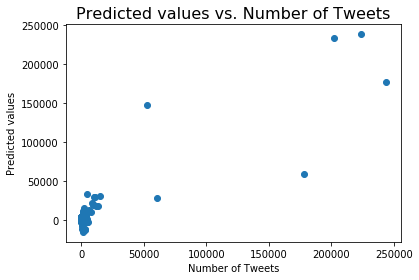

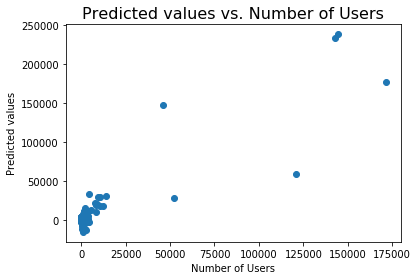

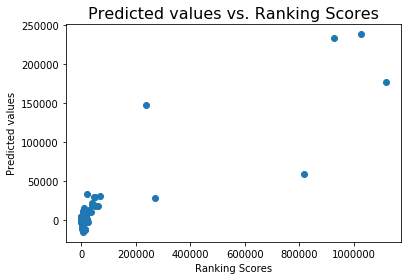

In [5]:
perform_linear_regression('#GoHawks')
perform_linear_regression('#GoPatriots')
perform_linear_regression('#NFL')
perform_linear_regression('#Patriots')
perform_linear_regression('#SB49')
perform_linear_regression('#SuperBowl')